# Text Analysis of Bloomberg Articles

## Analzying company sentiment using NLP models, Data Cleaning and EDA

## Regex, Pandas, Seaborn, Neural Network Models, Data Pipelines



Working with Bloomberg news articles on Microsoft and Microsoft stock data (MSFT).

Summary of methods:

- Conducting data cleaning and EDA on a text-based dataset,
- Manipulating data in `pandas` with the `datetime` and `string` accessors,
- Writing regular expressions and using `pandas` RegEx methods, and
- Performing sentiment analysis on text using DistilBERT.


In [37]:
import warnings
warnings.simplefilter(action="ignore")

import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ds100_utils import *

# Ensure that pandas shows at least 280 characters in columns, so we can see full articles.
pd.set_option("max_colwidth", 280)
plt.style.use("fivethirtyeight")
sns.set()
sns.set_context("talk")

In this assignment, we will use the DistilBERT model, which is a Natural Language Processing (NLP) model designed to understand human language by processing text to capture the context and meaning of words within sentences.

In [9]:
from transformers import pipeline
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"


##  Importing the Data

The data for this assignment is a subset of the financial news dataset from [this github repo](https://github.com/philipperemy/financial-news-dataset). The original datasets are no longer available online due to copyright issues, but I was allowed access for educational purposes. The data in the file `data/msft_bloomberg_news.txt` has been filtered to just Bloomberg articles published between 2010 to 2013 (inclusive) with text that contains "Microsoft" or "MSFT" (Microsoft's stock name).


<br>

---

### EDA




In [10]:
file = 'data/msft_bloomberg_news.txt'
with open(file) as f:
    q1a = f.read(1000)
print(q1a)


[{"id":46243185,"title":"Opera Jumps Most Ever After Report Facebook May Bid: Oslo Mover","released_at":"<date>May 29 2012<\/date> <time>09:40:58<\/time>","content":"Opera Software ASA (OPERA) , the Norwegian\nmarker of Internet browsers, surged the most on record in Oslo\nafter technology website  Pocket-Lint  reported that  Facebook Inc. (FB) \nmay try to acquire the company.  Opera gained as much as 26 percent, the biggest jump since\nit first sold shares in 2004. The Oslo-based company rose 18\npercent to 40.5 kroner at 11:37 a.m., giving it a market value\nof 4.85 billion kroner ($807 million).  Opera is the last major independent browser left, with the\nothers owned by companies such as  Microsoft Corp. (MSFT) ,  Google Inc. (GOOG)  \nand  Apple Inc. (AAPL) , said Aleksander Nilsen, an analyst at Abg Sundal\nCollier in Oslo. The company has a strong balance sheet, and\ncould be an attractive target for other companies, such as\n Mountain View , California-based Google, he said.  

In [11]:
q1b = 'C'

In [12]:
grader.check("q1b")

NameError: name 'grader' is not defined

In [13]:
msft_news_df = pd.read_json(r'data/msft_bloomberg_news.txt').set_index('id')
msft_news_df.head(1)

,title,released_at,content,path
id,,,,
46243185,Opera Jumps Most Ever After Report Facebook May Bid: Oslo Mover,<date>May 29 2012</date> <time>09:40:58</time>,"Opera Software ASA (OPERA) , the Norwegian\nmarker of Internet browsers, surged the most on record in Oslo\nafter technology website Pocket-Lint reported that Facebook Inc. (FB) \nmay try to acquire the company. Opera gained as much as 26 percent, the biggest jump since\n...",./2008_2012_msft_bloomberg_news/opera-jumps-most-on-record-after-report-of-facebook-s-interes.txt




### Analysis

Specating if we are interested in using the news to predict future stock values. What additional data would we need to predict stock prices

To assist in predicting future stock values it would be helpful to merge columns that join the corresponding company's stock ticker based on the time under 'released_at'. Additionally I would parse through the title and content to identify key words that may allude to an increase in stock valuation of a company such as "jumps" or "surges" (wording used in first entry columns). 


<br/>

<hr style="border: 1px solid #fdb515;" />

## Time Analysis

After loading in the data, we can start exploring news articles by analyzing the relationships between the release dates (date of publication) and different topics and companies.

<br>


---


EXAMPLES: of time
```
<date>May 29 2012</date> <time>09:40:58</time>
<date>May 18 2011</date> <time>22:42:40</time>
<date>August 15 2012</date> <time>00:09:02</time>
<date>July 1 2011</date> <time>22:12:37</time>
...
```

There are several ways to convert this to a `Timestamp` object that we can use more easily. Use regex such that:
1. The same index as `msft_news_df` (`id`) and
2. Column labels: `"Month"`, `"Day"`, `"Year"`, `"Hour"`, `"Minute"`, `"Second"`.

convert all numerical values (`"Year"`, `"Day"`, `"Hour"`, `"Minute"`, `"Second"`) to type `int`.


In [14]:
time_names = ["Month", "Day", "Year", "Hour", "Minute", "Second"]
data = pd.DataFrame(columns = time_names)


In [15]:
pattern = '>{1}([A-Za-z]+)\s+(\d{1,2})\s(\d{4})\<\/+[date]+\>\s+\<[time>]+(\d+):(\d+):(\d+)<'
dates = msft_news_df["released_at"].str.extract(pattern)
dates
for i in np.arange(1,6):
    dates[i] = dates[i].astype(int)
dates = dates.rename({0:"Month", 1:"Day", 2:"Year", 3:"Hour", 4:"Minute", 5:"Second"}, axis = 1)
dates

,Month,Day,Year,Hour,Minute,Second
id,,,,,,
46243185,May,29,2012,9,40,58
73522879,May,18,2011,22,42,40
29296500,August,15,2012,0,9,2
49799724,July,1,2011,22,12,37
20739032,January,18,2012,1,20,28
...,...,...,...,...,...,...
75325873,June,27,2012,0,35,58
49071474,September,24,2013,13,38,57
12417018,September,14,2011,4,1,0


In [16]:
temp = pd.merge(msft_news_df, dates, left_index = True, right_index = True)[["title", "released_at", "content", "path", "Month", "Day", "Year"]]
msft_news_2010 = temp.loc[temp['Year'] ==2010]
msft_news_2010.head(1)

,title,released_at,content,path,Month,Day,Year
id,,,,,,,
95357231,Netflix Profit Jumps 44% on New Users,<date>April 21 2010</date> <time>23:52:36</time>,"Netflix Inc. said first-quarter\nprofit rose 44 percent as the movie subscription service signed\nup new customers and increased online offerings. \n Net income advanced to $32.3 million, or 59 cents a share,\nfrom $22.4 million, or 37 cents, a year earlier, the Los Gatos,\n...",./2008_2012_msft_bloomberg_news/netflix-quarterly-profit-increases-44-as-movie-rental-service-adds-users.txt,April,21,2010


 adding a boolean column to the `msft_news_df` `DataFrame` indicating whether the corresponding company is mentioned in the text of the article. Also six new columns containing `True`/`False` values to the `DataFrame`: `"amazon"`, `"nintendo"`, `"apple"`, `"sony"`, `"facebook"`, `"netflix"`. 

In [17]:
companies = ["amazon", "nintendo", "apple", "sony", "facebook", "netflix"]

#for loop over each row in msft df and run another for loop iterating through each string in companies
#secondly assign each new company column a boolean whether the respective company is contained in the content 
#str.lower() the content column
msft_news_df['content'] = msft_news_df['content'].str.lower()
for company in companies:
    msft_news_df[company] = msft_news_df['content'].str.contains(company, case = True)
msft_news_df.head(1)

,title,released_at,content,path,amazon,nintendo,apple,sony,facebook,netflix
id,,,,,,,,,,
46243185,Opera Jumps Most Ever After Report Facebook May Bid: Oslo Mover,<date>May 29 2012</date> <time>09:40:58</time>,"opera software asa (opera) , the norwegian\nmarker of internet browsers, surged the most on record in oslo\nafter technology website pocket-lint reported that facebook inc. (fb) \nmay try to acquire the company. opera gained as much as 26 percent, the biggest jump since\n...",./2008_2012_msft_bloomberg_news/opera-jumps-most-on-record-after-report-of-facebook-s-interes.txt,False,False,True,False,True,False


In [18]:
companies + ['Year']

['amazon', 'nintendo', 'apple', 'sony', 'facebook', 'netflix', 'Year']

In [19]:
merged = pd.merge(msft_news_df, dates, left_index = True, right_index = True).loc[:, companies + ['Year']]
year_news = merged.loc[merged['Year'] >= 2010].groupby('Year').sum()
year_news

,amazon,nintendo,apple,sony,facebook,netflix
Year,,,,,,
2010,41,28,190,55,74,9
2011,101,29,477,104,158,43
2012,179,44,766,97,271,40
2013,152,93,687,196,238,51



#### Plot # of articles

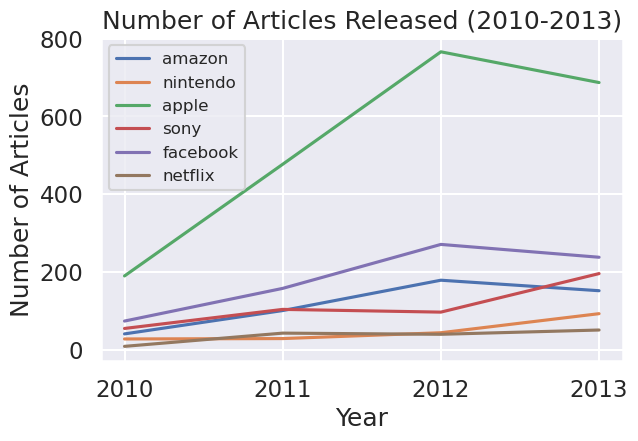

In [20]:
plt.figure(figsize=(6, 4))

for company in companies:
    sns.lineplot(data=year_news.reset_index(),
                 x="Year",
                 y=company,
                 label=company)
plt.legend(fontsize="12")
plt.xticks(np.arange(2010, 2014), np.arange(2010, 2014))
plt.ylabel("Number of Articles")
plt.xlabel("Year")
plt.title("Number of Articles Released (2010-2013)");

Reflection:

According to the plot, Apple received the most mentions within bloomberg articles from 2010 - 2013 relative to the other major companies by a significant margin. Pointing to the peak in 2012, there can be several factors and events in Apple's timeline that may have influenced this and caused media coverage. Such events includes the loss in life of Steve Jobs in 2011,  launch of the iPhone 5, trial case versus the rival Samsung and morality issues surrounding the outsourcing to China. As with any tragic loss of a public figure representing a major company or a pivotal court case, you can expect headlines surrounding these topics from major journals. 

Meanwhile, other companies tend to experience steady and consistent mentions throughout the plot. The data does not capture a company's relative performance as these mentions in the articles can have  a binary positive or negative story. Thus, the data without further manipulation cannot entail the performance of different companies as it is restricted to capturing the bloomberg coverage which can be biased based on the business model of Bloomberg and who they choose to report on.



## Sentiment Analysis


We will use a fine-tuned version of the **DistilBERT** model ([github](https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation), [original paper](https://arxiv.org/abs/1910.01108)) to analyze the sentiment of Bloomberg news articles. DistilBERT is a neural network-based language model (a close relative to ChatGPT);

We can use the [HuggingFace library](https://huggingface.co/) to build the sentiment analysis pipeline and load the model. 

In [21]:
# Load the model
sentiment_analysis = pipeline("sentiment-analysis", model=model_checkpoint)

# Get the sentiment of a given string
sentiment_1 = sentiment_analysis("I have two dogs.")
print("Example 1: " + str(sentiment_1))

sentiment_2 = sentiment_analysis("I do not have dogs.")
print("Example 2: " + str(sentiment_2))

sentiment_3 = sentiment_analysis("Fortunately, I do not have dogs to worry about.")
print("Example 3: " + str(sentiment_3))

Example 1: [{'label': 'POSITIVE', 'score': 0.9955033659934998}]
Example 2: [{'label': 'NEGATIVE', 'score': 0.9987561702728271}]
Example 3: [{'label': 'POSITIVE', 'score': 0.9975079298019409}]


As you can see, the model can determine the sentiment of phrases/sentences (not just words). The model measures the phrase's **polarity**, indicating how strongly negative or positive it is on a scale of 0 to 1.




In [22]:
sentiments = sentiment_analysis(["I have two dogs.", "I do not have dogs."])
print(sentiments[1])

{'label': 'NEGATIVE', 'score': 0.9987561702728271}


---

### To note


Due to model input size constraints, a maximum of 512 words (tokens), and limited computational resources on Datahub, we cannot load the full articles into the pipeline. Instead, we can look at the first sentence that mentions Microsoft in each article.

In [23]:
microsoft_re = '([^?.!]*(?:microsoft|msft)+[^?.!]*[.?!]+)'
msft_news_2010['content'] = msft_news_2010['content'].str.lower()
msft_news_2010['first_sentence'] = msft_news_2010['content'].str.findall(microsoft_re).str[0]
msft_news_2010.head(5)

,title,released_at,content,path,Month,Day,Year,first_sentence
id,,,,,,,,
95357231,Netflix Profit Jumps 44% on New Users,<date>April 21 2010</date> <time>23:52:36</time>,"netflix inc. said first-quarter\nprofit rose 44 percent as the movie subscription service signed\nup new customers and increased online offerings. \n net income advanced to $32.3 million, or 59 cents a share,\nfrom $22.4 million, or 37 cents, a year earlier, the los gatos,\n...",./2008_2012_msft_bloomberg_news/netflix-quarterly-profit-increases-44-as-movie-rental-service-adds-users.txt,April,21,2010,"\n “if we had offered a pay-per-view service for new\nreleases, we would be in conflict with a broad range of\ncompanies, including wal-mart, microsoft, sony and apple,”\nhastings said."
75227517,"Republican Win May Be Tax Boon for Companies, High Incomes",<date>November 3 2010</date> <time>16:46:00</time>,"americans with the highest incomes\nand u.s. corporations, especially those with international\noperations, stand to be big winners as newly elected\ncongressional republicans signal they will extend existing tax\nbenefits and push for new ones. republicans will use their ne...",./2008_2012_msft_bloomberg_news/republican-sweep-may-mean-tax-boon-for-u-s-multinationals-high-incomes.txt,November,3,2010,", microsoft corp."
57850804,Alibaba Says It Now Offers Sohu’s Search Engine,<date>October 29 2010</date> <time>12:23:43</time>,"alibaba group holding ltd. said\nusers of its search-engine service may now access technology\nsupplied by sohu.com inc. , as the two chinese companies \nstrengthen collaboration to challenge industry leader baidu inc. users of alibaba’s etao.com search service may now o...",./2008_2012_msft_bloomberg_news/alibaba-says-it-now-offers-sohu-s-search-engine.txt,October,29,2010,"com search service may now opt for\nthe sogou software, in addition to microsoft corp."
75532360,Slim Solution for Trade Imbalances Is More Buying by China,<date>October 31 2010</date> <time>16:05:40</time>,"billionaire carlos slim , the world’s\nrichest man, said china must buy more and the u.s. needs to step\nup private investment to reduce the trade imbalance and boost\ntheir economies. global currency devaluation efforts will fail in the\nabsence of economic policies that f...",./2008_2012_msft_bloomberg_news/slim-solution-for-trade-imbalances-is-more-buying-by-china-u-s-investing.txt,October,31,2010,"” gates, the co-founder of microsoft corp."
10176588,"S&P 500 to Defy `New Normal' and Rally 17%, Cambiar's Barish Says",<date>December 1 2010</date> <time>20:38:58</time>,"energy and industrial companies will\nrise next year, propelling a 17 percent gain in the standard &\npoor’s 500 index from its current level, according to cambiar\ninvestors llc’s brian barish . next year will be marked by a “multi-speed recovery” as\nindustries weakened b...",./2008_2012_msft_bloomberg_news/s-p-500-to-defy-pimco-s-new-normal-rise-17-by-end-of-2011-barish-says.txt,December,1,2010,"intel, microsoft corp."


#### Sentiment Analysis Model Application

determine the sentiment of the first sentence that mentions "microsoft" or "msft" for each article.

In [29]:
def sentiment_analysis_lite(lst):
    from ds100_utils import fetch_and_cache
    import pickle
    url = "https://github.com/DS-100/sp24/raw/main/resources/assets/datasets/hw3_sentiments.pkl"
    path = fetch_and_cache(url, "tmp-sentiment.pkl")
    with open(path, "rb") as f:
        out = pickle.load(f)
    return out

In [30]:
msft_news_2010['sentence_sentiment'] = sentiment_analysis_lite(msft_news_2010['content'].tolist())
msft_news_2010['sentence_sentiment'] = msft_news_2010['sentence_sentiment'].map(lambda x: x['score'])
msft_news_2010.head(1)

Using version already downloaded: Tue May 21 20:27:18 2024
MD5 hash of file: 87a3af05678bd284866a4623c22e7d0b


,title,released_at,content,path,Month,Day,Year,first_sentence,sentence_sentiment
id,,,,,,,,,
95357231,Netflix Profit Jumps 44% on New Users,<date>April 21 2010</date> <time>23:52:36</time>,"netflix inc. said first-quarter\nprofit rose 44 percent as the movie subscription service signed\nup new customers and increased online offerings. \n net income advanced to $32.3 million, or 59 cents a share,\nfrom $22.4 million, or 37 cents, a year earlier, the los gatos,\n...",./2008_2012_msft_bloomberg_news/netflix-quarterly-profit-increases-44-as-movie-rental-service-adds-users.txt,April,21,2010,"\n “if we had offered a pay-per-view service for new\nreleases, we would be in conflict with a broad range of\ncompanies, including wal-mart, microsoft, sony and apple,”\nhastings said.",0.998621




### Additional Dataset

turn to an alternative, more accurate way of determining the sentiment score of articles —— getting the sentiment based on the entire text, rather than getting sentiment based on the first sentence including "microsoft" or "msft" in the text. load new which contains sentiment scores of the full articles as a `DataFrame` `full_sentiments`. In this file, provided with logs which include the `id`, `score`, and `label` ("N" for "NEGATIVE" and "P" for "POSITIVE") in the following format: 

```
<device:1> <id:77243971> <result: [0.9963290095329285 (N)]>
<device:0> <id:14799046> <result: [0.9980687499046326 (N)]>
<device:1> <id:43064156> <result: [0.997868537902832 (N)]>
<device:1> <id:29402508> <result: [0.9924335479736328 (N)]>
...
```



In [31]:
full_sentiments = pd.read_csv('data/article_sentiment_logs.csv')
full_sentiments.head()

,RunNum,log
0,0,<device:0> <id:77243971> <result: [0.9963290095329285 (N)]>
1,1,<device:0> <id:14799046> <result: [0.9980687499046326 (N)]>
2,2,<device:0> <id:43064156> <result: [0.997868537902832 (N)]>
3,3,<device:0> <id:29402508> <result: [0.9924335479736328 (N)]>
4,4,<device:0> <id:71427879> <result: [0.9897157549858093 (N)]>


STEPS:

Using the logs, modify `full_sentiments` so it ultimately just contains the `id` and `content_score` (a number ranging from -1 to 1). 

Then, merge this with `msft_news_2010` so we can see the results of our two methods of calculating sentiment side by side. 

Assign this merged `DataFrame` to `msft_scores_2010`. 

After the merge, make sure that only articles from 2010 appear and that the index of the `DataFrame` is the article `id`.

need to negate the score of negatively classified articles (indicated by "N").


The articles have a primary key `id`.

reference how you calculated sentiment scores above.

In [32]:
regpattern = '<id:(\d+)'
regpattern_score = '\[(.*\))'
updated_scores_df = pd.DataFrame(columns = ['id', 'raw_score', 'letter', 'content_score'])
updated_scores_df['id'] = full_sentiments['log'].str.extract(regpattern).astype('int')
updated_scores_df['raw_score'] = full_sentiments['log'].str.extract(regpattern_score)
updated_scores_df['letter'] = updated_scores_df['raw_score'].str.split().str[1]
updated_scores_df['raw_score'] = updated_scores_df['raw_score'].str.split().str[0].astype('float')
updated_scores_df['content_score'] = updated_scores_df.loc[updated_scores_df['letter'] == '(N)']['raw_score'] *-1
updated_scores_df['content_score'] = updated_scores_df['content_score'].fillna(value=updated_scores_df['raw_score'])
updated_scores_df = updated_scores_df.loc[:, ['id', 'content_score']].set_index('id')
msft_scores_2010 = updated_scores_df.merge(msft_news_2010, left_index = True, right_index = True)
msft_scores_2010.head(1)

,content_score,title,released_at,content,path,Month,Day,Year,first_sentence,sentence_sentiment
id,,,,,,,,,,
78274823,-0.992596,"Stocks, Euro Gain After Greece Asks for Aid",<date>April 23 2010</date> <time>10:24:06</time>,stocks in europe rose and the euro\nstrengthened from a one-year low against the dollar after greece\nsaid it will ask the european union for a rescue package and\ngerman business confidence and earnings at companies including\nvolvo ab beat forecasts. greek stocks and bonds ...,./2008_2012_msft_bloomberg_news/stocks-euro-gain-after-greece-asks-for-aid.txt,April,23,2010,gains were\nlimited as microsoft corp.,0.996355




### Deeper Dive

In [35]:
msft_scores_2010['sentiment_difference'] = msft_scores_2010['sentence_sentiment'] - msft_scores_2010['content_score']
msft_scores_2010.head(1)

,content_score,title,released_at,content,path,Month,Day,Year,first_sentence,sentence_sentiment,sentiment_difference
id,,,,,,,,,,,
78274823,-0.992596,"Stocks, Euro Gain After Greece Asks for Aid",<date>April 23 2010</date> <time>10:24:06</time>,stocks in europe rose and the euro\nstrengthened from a one-year low against the dollar after greece\nsaid it will ask the european union for a rescue package and\ngerman business confidence and earnings at companies including\nvolvo ab beat forecasts. greek stocks and bonds ...,./2008_2012_msft_bloomberg_news/stocks-euro-gain-after-greece-asks-for-aid.txt,April,23,2010,gains were\nlimited as microsoft corp.,0.996355,1.988951


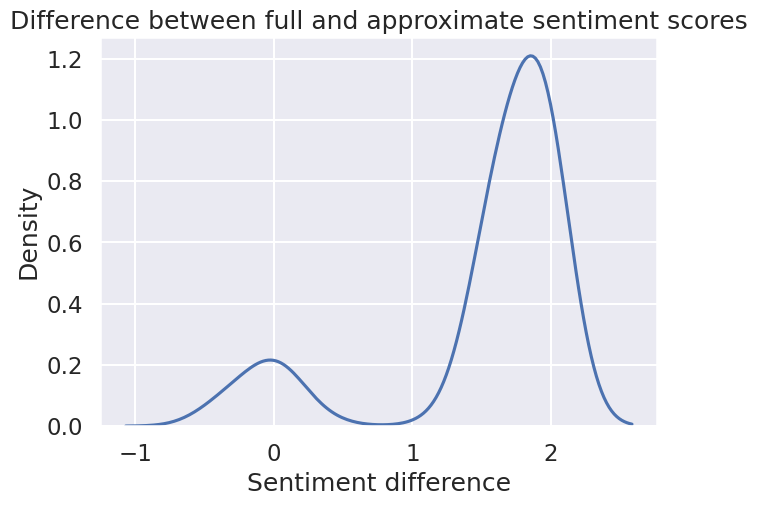

In [36]:
sns.kdeplot(msft_scores_2010['sentiment_difference'])
plt.xlabel('Sentiment difference')
plt.title('Difference between full and approximate sentiment scores');

Since we were strictly observing the first sentence of the article's content, the sentiment of the entire article and its stance was unclear. Oftentimes, articles present counterarguments that can steer the sentiment detection model towards the polar opposite or an author can simply be warming up into his main argument in revealing a negative sentiment despite the first sentence of the respective article expressing neutral sentiment. Therefore, it is extremeley important to gain context of the article and assess its sentiment upon full review to prevent misleading computational results. In the plot, we observe the density plot peaking at the difference of -2 with a density of >1, highlighting the differences amongst the full article's sentimenet against the first sentence's sentiment. 